In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor

plt.style.use('style.mpl')

# Linear fitting of pairwise proteome comparisons

Following Keren et al., MSB 2013, we perform robust linear regression of protein levels between pairs of *E. coli* growth conditions (quantitative proteomics from Schmidt et al. Nature Biotech. 2016). The regression slope is correlated to the ratio of growth rates between the conditions, with deviations from 1:1 at low and high ratios. 

In [2]:
raw_abund_df = pd.read_csv('../data/Chure_compiled_absolute_measurements.csv', index_col=0).reset_index().set_index('b_number')
gene_metadata_df = pd.read_csv('../data/ecoli_genelist_master.csv', index_col=1)

gene_metadata_df.head()

,gene_name,gene_product,mw_fg,go_terms,cog_class,cog_letter,cog_category,cog_desc
b_number,,,,,,,,
b4759,3'etsleuz,3'ETSleuZ,NaN,GO:0003723; GO:1904572,Not Assigned,Not Assigned,Not Assigned,Not Assigned
NaN,c0067,NaN,NaN,no ontology,NaN,NaN,NaN,NaN
NaN,c0293,NaN,NaN,no ontology,NaN,NaN,NaN,NaN
NaN,c0299,NaN,NaN,no ontology,NaN,NaN,NaN,NaN
NaN,c0362,NaN,NaN,no ontology,NaN,NaN,NaN,NaN


In [3]:
# Take the mean of replicates for the same gene. 
# Note 1: have to do this because the collated dataset we are using from
# Belliveau & Chure, Cell Systems 2021 didn't report which measurement is from which replicate.
# Note 2: the Schmidt data is already aggregated across two measurement methods.
# NB: Assuming same dataset, strain, cond, gene and growth rate implies replicate. 
counts = raw_abund_df.reset_index().groupby('dataset,strain,condition,b_number,growth_rate_hr'.split(',')).mean()
# renaming tot_per_cell for clarity and to match how we treat other datasets
abund_df = counts.reset_index().set_index('b_number').rename(
    columns=dict(tot_per_cell='copies_per_cell'))

# For calculating the relative mass contribution, we need to know the total.
total_mass_per_cond = abund_df.groupby('dataset,condition'.split(',')).agg(dict(fg_per_cell='sum'))
total_mass_per_cond.rename(dict(fg_per_cell='total_mass_fg'), axis=1, inplace=True)

# Merge this back into the abund_df
abund_df = abund_df.reset_index().set_index(
    'dataset,condition'.split(',')).merge(
        total_mass_per_cond, left_index=True,
        right_index=True).reset_index().set_index('b_number')

# Calculate the relative mass contribution of each gene to the total.
abund_df['mass_fraction'] = abund_df.fg_per_cell / abund_df.total_mass_fg

# Save the abund_df
abund_df.to_csv('../data/Chure_mean_abundance_measurements.csv')

# Get the Schmidt et al. 2016 data specifically and save it.
schmidt_data = abund_df[abund_df.dataset == 'schmidt_2016']
schmidt_data.to_csv('../data/schmidt_2016_mean_abundance_measurements.csv') 

In [4]:
# Conditions of interest -- single carbon sources in batch
conds = ['fructose', 'fumarate', 'galactose',
         'glucosamine', 'glucose', 'glycerol',
         'mannose', 'pyruvate', 'succinate', 'xylose']

# Get the growth rates for each condition
lambdas = abund_df.groupby('dataset,condition'.split(',')).growth_rate_hr.first()
cond_lambdas = lambdas.loc['schmidt_2016', conds].reset_index().drop('dataset', axis=1).set_index('condition')

In [5]:
mask = np.logical_and(
    abund_df.condition.isin('glucose,glycerol'.split(',')),
    abund_df.dataset == 'schmidt_2016')
two_conds = abund_df[mask].reset_index().pivot(
    index='b_number', columns='condition', values='copies_per_cell')

In [6]:
# Consider single carbon source conditions only
# Get the growth rates for each condition
res_dict = dict(lambda_a=[], lambda_b=[], condition_a=[], condition_b=[], regression_slope=[],
                huber_regression_slope=[], ransac_regression_slope=[], est_slope=[])
for a, b in itertools.permutations(conds, 2):
    print(a, b)
    a_vals = schmidt_data[schmidt_data.condition == a].copies_per_cell
    b_vals = schmidt_data[schmidt_data.condition == b].copies_per_cell

    a_not_null = a_vals[a_vals.notnull()]
    b_not_null = b_vals[b_vals.notnull()]
    shared_ids = sorted(set(a_not_null.index).intersection(set(b_not_null.index)))
    a_vals = a_not_null.loc[shared_ids]
    b_vals = b_not_null.loc[shared_ids]

    # Various ways of estimating the slope
    # Standard linear regression
    lr = LinearRegression(fit_intercept=False)
    lr.fit(a_vals.values.reshape(-1, 1), b_vals.values.reshape(-1, 1))

    # Huber regression -- more robust to outliers
    hr = HuberRegressor(fit_intercept=False)
    hr.fit(a_vals.values.reshape(-1, 1), b_vals.values.reshape(-1, 1))

    # Random sample consensus regression -- more robust to outliers also
    base_estimator = LinearRegression(fit_intercept=False)
    rr = RANSACRegressor(base_estimator)
    rr.fit(a_vals.values.reshape(-1, 1), b_vals.values.reshape(-1, 1))

    # Estimate the slope of a linear regression by assuming the intercept is zero
    # and taking the mean of the log ratios to get the slope.
    mean_log_a = np.nanmean(np.log10(a_vals[a_vals > 0]))
    mean_log_b = np.nanmean(np.log10(b_vals[b_vals > 0]))
    est_log_intercept = mean_log_b - mean_log_a
    est_linear_slope = np.power(10, est_log_intercept)

    # make a little figure for each correlation that we calculate
    plt.figure()
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(a_vals, b_vals, label='{0} vs {1}'.format(a, b))
    xs = np.linspace(a_vals.min(), a_vals.max(), 100)
    plt.plot(xs, hr.predict(xs.reshape(-1, 1)), color='grey', ls='--', label='regression')
    plt.title('{0} vs {1}'.format(a, b))

    lambda_ratio = cond_lambdas.loc[b].growth_rate_hr / cond_lambdas.loc[a].growth_rate_hr
    plt.text(0.1, 0.9, '$y =$ {0:.2f} $x$; $\lambda_2 / \lambda_1 =$ {1:.2f}'.format(lr.coef_[0][0], lambda_ratio), 
             ha='left', transform=plt.gca().transAxes)
    plt.xlabel('{0}, $\lambda_1$={1:.2f}'.format(a, cond_lambdas.loc[a].growth_rate_hr))
    plt.ylabel('{0}, $\lambda_2$={1:.2f}'.format(b, cond_lambdas.loc[b].growth_rate_hr))
    plt.savefig('../output/{0}_vs_{1}.png'.format(a, b), facecolor='w', dpi=300)
    plt.close()
    
    lambda_a = cond_lambdas.loc[a].growth_rate_hr
    lambda_b = cond_lambdas.loc[b].growth_rate_hr
    
    res_dict['lambda_a'].append(lambda_a)
    res_dict['lambda_b'].append(lambda_b)
    res_dict['condition_a'].append(a)
    res_dict['condition_b'].append(b)
    res_dict['est_slope'].append(est_linear_slope)
    res_dict['regression_slope'].append(lr.coef_[0][0])
    res_dict['huber_regression_slope'].append(hr.coef_[0])
    res_dict['ransac_regression_slope'].append(rr.estimator_.coef_[0][0])

slopes_df = pd.DataFrame(res_dict).set_index('condition_a,condition_b'.split(','))
slopes_df['lambda_ratio'] = slopes_df['lambda_b'] / slopes_df['lambda_a']
slopes_df.to_csv('../data/schmidt_2016_regression_slopes.csv', index=True)
slopes_df.head()

fructose fumarate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fructose galactose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fructose glucosamine


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fructose glucose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fructose glycerol


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fructose mannose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fructose pyruvate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fructose succinate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fructose xylose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fumarate fructose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fumarate galactose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fumarate glucosamine


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fumarate glucose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fumarate glycerol


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fumarate mannose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fumarate pyruvate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fumarate succinate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fumarate xylose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


galactose fructose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


galactose fumarate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


galactose glucosamine


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


galactose glucose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


galactose glycerol


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


galactose mannose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


galactose pyruvate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


galactose succinate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


galactose xylose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucosamine fructose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucosamine fumarate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucosamine galactose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucosamine glucose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucosamine glycerol


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucosamine mannose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucosamine pyruvate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucosamine succinate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucosamine xylose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucose fructose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucose fumarate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucose galactose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucose glucosamine


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucose glycerol


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucose mannose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucose pyruvate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucose succinate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glucose xylose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glycerol fructose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glycerol fumarate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glycerol galactose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glycerol glucosamine


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glycerol glucose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glycerol mannose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glycerol pyruvate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glycerol succinate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


glycerol xylose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mannose fructose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mannose fumarate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mannose galactose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mannose glucosamine


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mannose glucose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mannose glycerol


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mannose pyruvate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mannose succinate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mannose xylose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pyruvate fructose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pyruvate fumarate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pyruvate galactose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pyruvate glucosamine


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pyruvate glucose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pyruvate glycerol


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pyruvate mannose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pyruvate succinate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


pyruvate xylose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


succinate fructose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


succinate fumarate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


succinate galactose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


succinate glucosamine


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


succinate glucose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


succinate glycerol


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


succinate mannose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


succinate pyruvate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


succinate xylose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xylose fructose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xylose fumarate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xylose galactose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xylose glucosamine


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xylose glucose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xylose glycerol


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xylose mannose


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xylose pyruvate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xylose succinate


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


lambda_a  lambda_b  regression_slope  \
condition_a condition_b                                         
fructose    fumarate         0.65      0.42          0.761772   
            galactose        0.65      0.26          0.612077   
            glucosamine      0.65      0.46          0.800149   
            glucose          0.65      0.58          0.987564   
            glycerol         0.65      0.47          0.826714   

                         huber_regression_slope  ransac_regression_slope  \
condition_a condition_b                                                    
fructose    fumarate                   0.733766                 0.848524   
            galactose                  0.565319                 0.605675   
            glucosamine                0.784260                 0.886961   
            glucose                    0.957096                 0.912154   
            glycerol                   0.810691                 0.850275   

                         est_slope  lambda_ratio  
condition_a condition_b                           
fructose    fumarate      0.819025      0.646154  
            galactose     0.718052      0.400000  
            glucosamine   0.888979      0.707692  
            glucose       0.929259      0.892308  
            glycerol      0.869154      0.723077

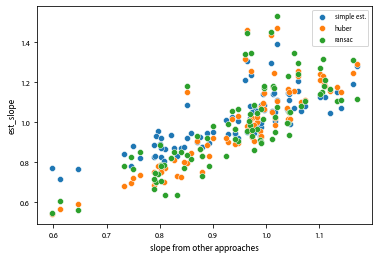

In [7]:
sns.scatterplot(data=slopes_df, x='regression_slope', y='est_slope', label='simple est.')
sns.scatterplot(data=slopes_df, x='regression_slope', y='huber_regression_slope', label='huber')
sns.scatterplot(data=slopes_df, x='regression_slope', y='ransac_regression_slope', label='ransac')
plt.xlabel('slope from ordinary least squares')
plt.xlabel('slope from other approaches')
plt.show()

In [8]:
sns.scatterplot?

Signature:
sns.scatterplot(
    *,
    x=None,
    y=None,
    hue=None,
    style=None,
    size=None,
    data=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    sizes=None,
    size_order=None,
    size_norm=None,
    markers=True,
    style_order=None,
    x_bins=None,
    y_bins=None,
    units=None,
    estimator=None,
    ci=95,
    n_boot=1000,
    alpha=None,
    x_jitter=None,
    y_jitter=None,
    legend='auto',
    ax=None,
    **kwargs,
)
Docstring:
Draw a scatter plot with possibility of several semantic groupings.

The relationship between ``x`` and ``y`` can be shown for different subsets
of the data using the ``hue``, ``size``, and ``style`` parameters. These
parameters control what visual semantics are used to identify the different
subsets. It is possible to show up to three dimensions independently by
using all three semantic types, but this style of plot can be hard to
interpret and is often ineffective. Using redundant semantics (i.e. both
``hue``

In [9]:
tmp2 = gene_metadata_df[gene_metadata_df.gene_product.notnull()].copy()
mask = tmp2.gene_product.str.contains('ribosomal')
tmp2[mask]


,gene_name,gene_product,mw_fg,go_terms,cog_class,cog_letter,cog_category,cog_desc
b_number,,,,,,,,
b2511,der,50S ribosomal subunit stability factor,0.000091,GO:0005515; GO:0043023; GO:0097216; GO:0005829...,poorly characterized,R,general function prediction only,GTPase; multicopy suppressor of ftsJ
b2511,yfgk,50S ribosomal subunit stability factor,0.000091,GO:0005515; GO:0043023; GO:0097216; GO:0005829...,poorly characterized,R,general function prediction only,GTPase; multicopy suppressor of ftsJ
b2511,enga,50S ribosomal subunit stability factor,0.000091,GO:0005515; GO:0043023; GO:0097216; GO:0005829...,poorly characterized,R,general function prediction only,GTPase; multicopy suppressor of ftsJ
b2566,era,30S ribosomal subunit maturation GTPase Era,0.000056,GO:0000028; GO:0097216; GO:0005515; GO:0046777...,information storage and processing,J,"translation, ribosomal structure and biogenesis","membrane-associated, 16S rRNA-binding GTPase"
b2566,sdge,30S ribosomal subunit maturation GTPase Era,0.000056,GO:0000028; GO:0097216; GO:0005515; GO:0046777...,information storage and processing,J,"translation, ribosomal structure and biogenesis","membrane-associated, 16S rRNA-binding GTPase"
...,...,...,...,...,...,...,...,...
b1480,protein d,30S ribosomal subunit protein S22,0.000008,GO:0005737; GO:0022627; GO:0005829; GO:0006412...,Not Assigned,Not Assigned,Not Assigned,Not Assigned
b0905,ycao,ribosomal protein S12 methylthiotransferase ac...,0.000109,GO:0000287; GO:0047693; GO:0005829; GO:0018339,information storage and processing,J,"translation, ribosomal structure and biogenesis",conserved protein
b0905,protein involved in &beta;-methylthiolation of...,ribosomal protein S12 methylthiotransferase ac...,0.000109,GO:0000287; GO:0047693; GO:0005829; GO:0018339,information storage and processing,J,"translation, ribosomal structure and biogenesis",conserved protein


alpha_est_1 = 0.17
alpha_est_2 = 0.25


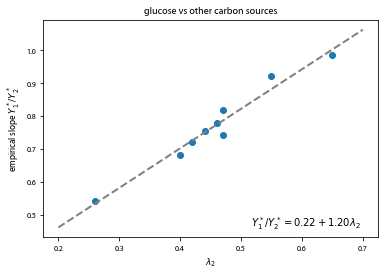

In [10]:
mask = np.logical_or(slopes_df.index.get_level_values(0) == 'glucose',
                     slopes_df.index.get_level_values(1) == 'glucose')
glucose_slopes = slopes_df[mask].reset_index()
glucose_slopes

xvals, yvals = [], []
mask = glucose_slopes.condition_a == 'glucose'
plt.scatter(glucose_slopes[mask].lambda_b, glucose_slopes[mask].huber_regression_slope, label='glucose')
yvals.extend(glucose_slopes[mask].huber_regression_slope)
xvals.extend(glucose_slopes[mask].lambda_b)

reg = linregress(xvals, yvals)
xs = np.linspace(0.2, 0.7, 100)
plt.plot(xs, reg.slope*xs + reg.intercept, color='grey', ls='--')
plt.text(0.95, 0.05, '$Y^*_1 / Y^*_2 = {0:.2f} + {1:.2f} \lambda_2$'.format(reg.intercept, reg.slope),
         transform=plt.gca().transAxes, ha='right')
plt.xlabel('$\lambda_2$')
plt.ylabel('empirical slope $Y^*_1 / Y^*_2$')
plt.title('glucose vs other carbon sources')

lambda_1 = cond_lambdas.loc['glucose'].growth_rate_hr
alpha_est_1 = reg.intercept * lambda_1 / (1-reg.intercept)
alpha_est_2 = 1/reg.slope - lambda_1
print('alpha_est_1 = {0:.2f}'.format(alpha_est_1))
print('alpha_est_2 = {0:.2f}'.format(alpha_est_2))
plt.show()

alpha_est_1 = 0.19
alpha_est_2 = 0.17

alpha_est_1 = 0.30
alpha_est_2 = 0.33

alpha_est_1 = 0.43
alpha_est_2 = 0.46

alpha_est_1 = 0.23
alpha_est_2 = 0.28

alpha_est_1 = 0.17
alpha_est_2 = 0.25

alpha_est_1 = 0.21
alpha_est_2 = 0.25

alpha_est_1 = 0.32
alpha_est_2 = 0.29

alpha_est_1 = 0.30
alpha_est_2 = 0.32

alpha_est_1 = 0.24
alpha_est_2 = 0.27

alpha_est_1 = 0.15
alpha_est_2 = 0.20



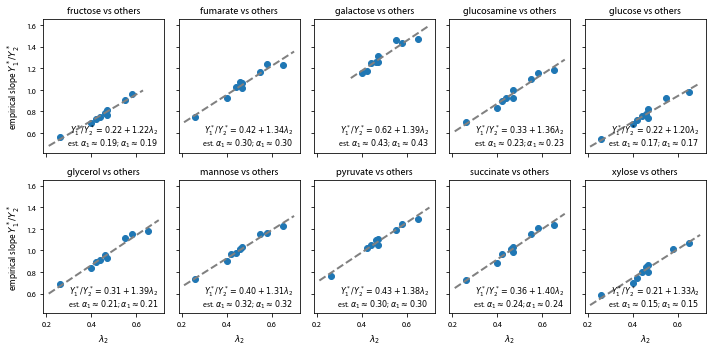

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), sharex=True, sharey=True)
flat_axs = axs.flatten()

for i, (cond_id, cond_df) in enumerate(slopes_df.reset_index().groupby('condition_a')):
    reg = linregress(cond_df.lambda_b, cond_df.huber_regression_slope)

    lambda_1 = cond_lambdas.loc[cond_id].growth_rate_hr
    alpha_est_1 = reg.intercept * lambda_1 / (1-reg.intercept)
    alpha_est_2 = 1/reg.slope - lambda_1
    print('alpha_est_1 = {0:.2f}'.format(alpha_est_1))
    print('alpha_est_2 = {0:.2f}'.format(alpha_est_2))
    print()

    plt.sca(flat_axs[i])
    plt.scatter(cond_df.lambda_b, cond_df.huber_regression_slope, label=cond_id)

    xmin = cond_df.lambda_b.min()
    xmax = cond_df.lambda_b.max()
    xs = np.linspace(xmin-0.05, xmax+0.05, 100)
    plt.plot(xs, reg.slope*xs + reg.intercept, color='grey', ls='--')
    plt.text(0.95, 0.15, '$Y^*_1 / Y^*_2 = {0:.2f} + {1:.2f} \lambda_2$'.format(reg.intercept, reg.slope),
            transform=plt.gca().transAxes, ha='right', fontsize=8)
    plt.text(0.95, 0.05, 'est. $\\alpha_1 \\approx {0:.2f}$; $\\alpha_1 \\approx {0:.2f}$'.format(alpha_est_1, alpha_est_2),
             transform=plt.gca().transAxes, ha='right', fontsize=8)
    
    if i > 4:
        plt.xlabel('$\lambda_2$')
    if i % 5 == 0:
        plt.ylabel('empirical slope $Y^*_1 / Y^*_2$')
    
    plt.title('{0} vs others'.format(cond_id))

plt.tight_layout()
plt.savefig('../output/est_alpha.png', facecolor='white', dpi=300)
plt.show()

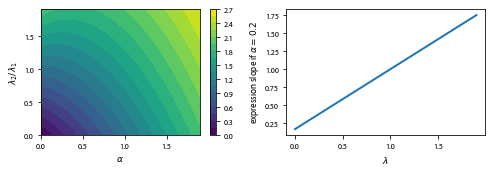

In [12]:
# Plot the expected ratio of Y1/Y2 as a function of lambda_2 
# for different values of alpha (degradation) assuming 
# a reference lambda_1 of 1.0 hr^-1
alphas = np.arange(0, 2, 0.1)
lambdas = np.arange(0, 2, 0.1)

A, L = np.meshgrid(alphas, lambdas)

R = A + L / (1+A)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 2.5))

plt.sca(axs[0])
plt.contourf(A, L, R, levels=20)
plt.xlabel('$\\alpha$')
plt.ylabel('$\lambda_2 / \lambda_1$')
plt.colorbar()

plt.sca(axs[1])

ratio = (0.2 + lambdas) / (1 + 0.2)
plt.plot(lambdas, ratio)
plt.xlabel('$\\lambda$')
plt.ylabel('expression slope if $\\alpha = 0.2$')

plt.tight_layout()
plt.show()